Fashion-MNIST dataset consists of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes

In [13]:
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np

# Configuration of CUDA (GPU support for PyTorch) that can be used while loading the data.
# And later to my __getitem__ function I will pass this device variable
# device = "cuda" if torch.cuda.is_available() else "cpu"

# In my case, although I have PyTorch recognizable NVIDIA GPU and so torch.cuda.is_available()
# will return TRUE, but my GPU's computer capability is < 3.5 and so will NOT work with PyTorch
device = "cpu"

In [14]:

root_input_dataset_dir = './input_dataset'

fmnist = torchvision.datasets.FashionMNIST(root_input_dataset_dir, download=True, train=True)
# fmnist = torchvision.root_input_dataset_dir.FashionMNIST(root_input_dataset_dir, download=True, train=True, transform=transforms.ToTensor())

img.size  (28, 28)
label  9


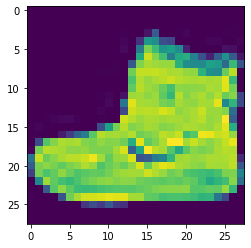

In [15]:

img, label = fmnist[0] # You’ll get a tuple with a Pillow image and an integer label back:
print("img.size ", img.size)
print("label ", label)
plt.imshow(img)

In [16]:
# store the images and the labels
train_images = fmnist.data
train_img_targets = fmnist.targets

Check any random single image from the train_images dataset.

In [17]:
class DatasetTransformer(Dataset):
  """ Will take 2 arrays/tensors for parameters train_images (x) and train_img_targets (y) """
  def __init__(self, x, y):
    # converting the input into a floating-point number 
    # x = x.float()
    
    # And also scale them to the range of [0,1]
    # This can be achieved by dividing all pixels values by the largest pixel value; that is 255. 
    # This is performed across all channels, regardless of the actual range of pixel values that are present in the image.
    x = x.float()/255
    
    # flattened each image into 28*28 = 784 numeric values
    # where each numeric value corresponds to a pixel value
    x = x.view(-1, 28 * 28)
    self.x, self.y = x, y    
    
    
  # __getitem__ function returns a sample from the dataset given an index.
  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]    
    # It is necessary to have both the model, and the data on the same device, 
    # either CPU or GPU, for the model to process data. 
    # Data on CPU and model on GPU, or vice-versa, will result in a Runtime error.
    # to(device) => this method will move the tensor or model to the specified device.
    return x.to(device), y.to(device)
    
  # __len__ function which returns the size of the dataset, 
  def __len__(self):
    return len(self.x)
  

Create a function that generates a training DataLoader – train_dataloader from the dataset. This will sample 32 data points at random for the batch size:

In [18]:
def load_data():
  train_data = DatasetTransformer(train_images, train_img_targets)
  train_loaded_data = DataLoader(train_data, batch_size=32, shuffle=True)
  return train_loaded_data

The 32 in above is coming because I have stated `batch_size=32` in DataLoader

And the 784 is coming because, I have taken the 1 * 28 * 28 size image and flattened it to 784 inside the `__init__` function

In [19]:
from torch.optim import SGD

def run_model():
  model = nn.Sequential(
    nn.Linear(28 * 28,  1000),
    nn.ReLU(),
    nn.Linear(1000, 10)
  ).to(device)
  
  loss_fn = nn.CrossEntropyLoss()
  optimizer = SGD(model.parameters(), lr=0.01)
  return model, loss_fn, optimizer

In [20]:
def trainer_each_batch(x, y, model, optimizer, loss_fn):
    model.train()
    # call model on the batch of inputs
    # `model.train()` tells your model that you are training the model. 
    # So BatchNorm layers use per-batch statistics and Dropout layers are activated etc
    # Forward pass: Compute predicted y by passing x to the model
    prediction = model(x) 
    # "prediction = model(x)" executes forward propagation over x 
    
    # compute loss
    loss_for_this_batch = loss_fn(prediction, y)
    
    # based on the forward pass in `model(x)` compute all the gradients of model.parameters()
    # loss.backward() computes dloss/dx for every parameter x 
    # which has requires_grad=True. These are accumulated into x.grad for every parameter x.
    # In pseudo-code:
    # x.grad += dloss/dx
    loss_for_this_batch.backward()
    
    """ apply new-weights = f(old-weights, old-weight-gradients) where "f" is the optimizer 
    When you call `loss.backward()`, all it does is compute gradient of loss w.r.t all the parameters in loss that have `requires_grad = True` and store them in `parameter.grad` attribute for every parameter.

    `optimizer.step()` updates all the parameters based on `parameter.grad`
    """
    
    optimizer.step()
    
    # Flush gradients memory for next batch of calculations
    # `optimizer.zero_grad()` clears `x.grad` for every parameter x in the optimizer.
    # Not zeroing grads would lead to gradient accumulation across batches.
    optimizer.zero_grad()
    
    return loss_for_this_batch.item()

The trainer_each_batch function does the following this

1. Passes the batch of images through the model in the forward pass. 
3. Computes the loss on batch
4. Then passes the weights through backward propagation and updates them. 
5. Finally, it flushes the memory of the gradient so that it doesn't influence how the gradient is calculated in the next pass.

In [21]:
""" torch.no_grad() impacts the autograd engine and deactivate it. It will reduce memory usage and speed up computations but you won’t be able to backprop (which you don’t want in an eval script). 
So torch.no_grad() basically skips the gradient calculation over the weights. That means you are not changing any weight in the specified layers. 

If you are training pre-trained model, it's ok to use torch.no_grad() on all the layers except fully connected layer or classifier layer.

"""
@torch.no_grad()

def accuracy(x, y, model):
  
    # model.eval() will notify all your layers that you are in eval mode,
    # that way, batchnorm or dropout layers will work in eval mode instead of training mode.  
    model.eval()
    
    # get the prediction matrix for a tensor of `x` images
    prediction = model(x)
    
    # Now compute if the location of maximum in each row coincides with ground truth
    # For that first, I am identifying the argmax index corresponding to each row with prediction.max(-1)
    max_values, argmaxes = prediction.max(-1)

    """ comparing argmaxes with the ground truth through with argmaxes == y
    to check that each row is predicted correctly.  """
    
    is_correct = argmaxes == y
    
    return is_correct.cpu().numpy().tolist()

In [22]:
training_data_loader = load_data()
model, loss_fn, optimizer = run_model()

In [23]:
losses, accuracies = [], []
for epoch in range(5):
    print(epoch)
    
    # Creating lists that will contain the accuracy and loss values corresponding to each batch within an epoch:
    losses_in_this_epoch, accuracies_in_this_epoch = [], []
    
    # Create batches of training data by iterating through the DataLoader:
    for ix, batch in enumerate(iter(training_data_loader)):
        x, y = batch
        """ Train the batch using the trainer_each_batch() function and store the loss value at
        the end of training on top of the batch as loss_for_this_batch. 
        Furthermore, store the loss values across batches in the losses_in_this_epoch list:
        """
        loss_for_this_batch = trainer_each_batch(x, y, model, optimizer, loss_fn)
        losses_in_this_epoch.append(loss_for_this_batch)
    
    # After the above loop is done 
    # store the mean loss value across all batches within an epoch:    
    epoch_loss = np.array(losses_in_this_epoch).mean()
    
    
    # Next, we calculate the accuracy of the prediction at the end of training on all batches:
    for ix, batch in enumerate(iter(training_data_loader)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        accuracies_in_this_epoch.extend(is_correct)
    epoch_accuracy = np.mean(accuracies_in_this_epoch)
    
    losses.append(epoch_loss)
    
    accuracies.append(epoch_accuracy)

0
1
2
3
4


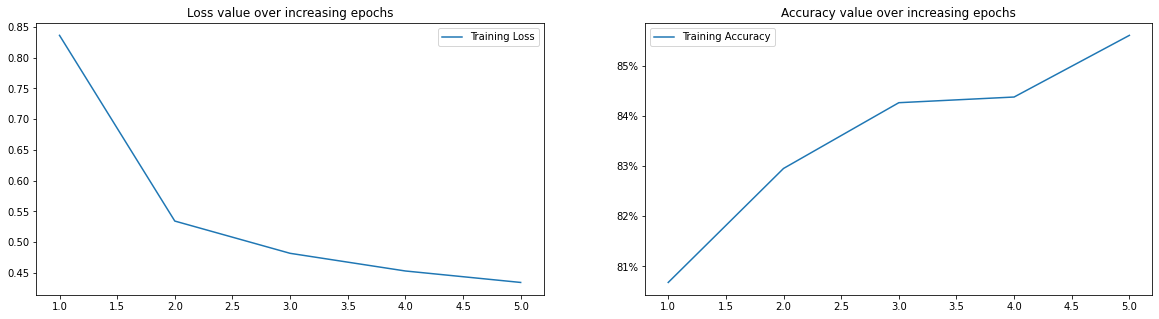

In [24]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()